# 违反回归模型
By Evgenia "Jenny" Nitishinskaya and Delaney Mackenzie

Part of the Quantopian Lecture Series:

* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [github.com/quantopian/research_public](https://github.com/quantopian/research_public)

---

当使用回归来将模型拟合到我们的数据时，必须满足回归分析的假设，以确保良好的参数估计和准确的拟合统计。我们希望参数是:
* 无偏的(不同样本的期望值为真实值)
* 一致的(与多个样本的真实值一致)
* 有效的(方差最小化)

下面我们研究了这些假设可能被违反的方式，以及对参数和拟合统计的影响。我们将在示例中使用单变量线性方程，但是同样的考虑也适用于其他模型。我们还假设我们的模型是正确指定的;也就是说，我们选择的函数形式是有效的。我们将在另一个笔记本中讨论模型规范错误以及它们所导致的假设违背和其他问题。

# 关注残差

与其专注于你的模型构建，还不如从你的残差(误差)中获取大量的信息。您的模型可能非常复杂，无法分析，但是只要您有预测和观察到的值，您就可以计算残差。一旦有了残差，就可以执行许多统计测试。

如果你的残差不符合一个给定的分布(通常是正态的，但是取决于你的模型)，那么你就知道有些地方出了问题，你应该关注你的预测的准确性。

# 残差不是正态分布

如果误差项不是正态分布，那么我们的统计显著性检验就不成立了。幸运的是，中心极限定理告诉我们，对于足够大的数据样本，即使误差不是正态分布，系数分布也会接近正态分布。因此，我们的分析仍然适用于大型数据集。

## 测试正态

Jarque-Bera测试是检验是否正态的一个好方法。它有一个`statsmodels.stats.stattools.jarque_bera`的python实现，我们将在这节课经常使用它。

### 总是检查是否正态!

这非常简单，可以节省你大量的时间。

In [1]:
# Import all the libraries we'll be using
import numpy as np
import statsmodels.api as sm
from statsmodels import regression, stats
import statsmodels
import matplotlib.pyplot as plt

In [4]:
residuals = np.random.normal(0, 1, 100)

_, pvalue, _, _ = statsmodels.stats.stattools.jarque_bera(residuals)
print(pvalue) 

residuals = np.random.poisson(size = 100)

_, pvalue, _, _ = statsmodels.stats.stattools.jarque_bera(residuals)
print(pvalue) 

0.8592255265777812
0.001307345710590348


# 异方差性

异方差性是指各观测值之间误差项的方差不是常数。直观地说，这意味着观测结果并不是均匀地分布在回归线上。这种情况经常发生在横断面数据中，我们所测量的样本的差异导致了方差的差异。

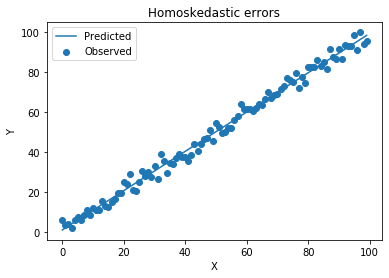

In [8]:
# Artificially create dataset with constant variance around a line
xs = np.arange(100)
y1 = xs + 3*np.random.randn(100)

# Get results of linear regression
slr1 = regression.linear_model.OLS(y1, sm.add_constant(xs)).fit()

# Construct the fit line
fit1 = slr1.params[0] + slr1.params[1]*xs

# Plot data and regression line
plt.scatter(xs, y1)
plt.plot(xs, fit1)
plt.title('Homoskedastic errors');
plt.legend(['Predicted', 'Observed'])
plt.xlabel('X')
plt.ylabel('Y');

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.390
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     62.53
Date:                Sun, 19 Apr 2020   Prob (F-statistic):           3.99e-12
Time:                        22:30:41   Log-Likelihood:                -497.51
No. Observations:                 100   AIC:                             999.0
Df Residuals:                      98   BIC:                             1004.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0699      7.024      0.152      0.879     -12.869      15.009
x1             0.9693      0.123      7.908      0.000       0.726       1.213
==============================================================================
Omnibus:                       18.519   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.426
Skew:                           0.535   Prob(JB):                     2.50e-12
Kurtosis:                       6.417   Cond. No.                         114.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

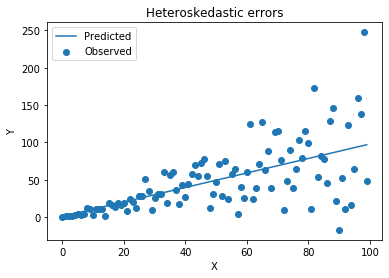

In [9]:
# Artificially create dataset with changing variance around a line
y2 = xs*(1 + .5*np.random.randn(100))

# Perform linear regression
slr2 = regression.linear_model.OLS(y2, sm.add_constant(xs)).fit()
fit2 = slr2.params[0] + slr2.params[1]*xs

# Plot data and regression line
plt.scatter(xs, y2)
plt.plot(xs, fit2)
plt.title('Heteroskedastic errors')
plt.legend(['Predicted', 'Observed'])
plt.xlabel('X')
plt.ylabel('Y')

# Print summary of regression results
slr2.summary()

### 异方差性检验

您可以使用一些测试来测试异方差，我们将使用statsmodels库中的Breush Pagan测试。我们还将测试正态性，在本例中，正态性也包含第二种情况的怪异之处。然而，残差也有可能是正态分布的，它也是异方差的，所以必须同时进行这两个测试来确定。

In [11]:
residuals1 = y1-fit1
residuals2 = y2-fit2

xs_with_constant = sm.add_constant(xs)

_, jb_pvalue1, _, _ = statsmodels.stats.stattools.jarque_bera(residuals1)
_, jb_pvalue2, _, _ = statsmodels.stats.stattools.jarque_bera(residuals2)
print("p-value for residuals1 being normal", jb_pvalue1) 
print("p-value for residuals2 being normal", jb_pvalue2) 

_, pvalue1, _, _ = stats.diagnostic.het_breuschpagan(residuals1, xs_with_constant)
_, pvalue2, _, _ = stats.diagnostic.het_breuschpagan(residuals2, xs_with_constant)
print("p-value for residuals1 being heteroskedastic", pvalue1) 
print ("p-value for residuals2 being heteroskedastic", pvalue2)

p-value for residuals1 being normal 0.5717064700525956
p-value for residuals2 being normal 2.5037616061813207e-12
p-value for residuals1 being heteroskedastic 0.6961647107226101
p-value for residuals2 being heteroskedastic 2.0003113271144293e-06


### 纠正异方差性

异方差如何影响我们的分析?当误差方差与上述自变量相关时，问题就出现了，即条件异方差。这使得回归显著性的F检验和个别系数显著性的t检验不可靠。这通常会导致对拟合重要性的高估。

breusch-pagan检验和White检验可用于检测条件异方差。如果我们怀疑这种影响的存在，我们可以改变我们的模型，尝试并纠正它。一种方法是广义最小二乘法，它需要对原始方程进行手动修改。另一种方法是计算稳健的标准误差，修正拟合统计量以解释异方差。`statsmodels`可以计算稳健的标准误差;请注意下面统计数据中的差异。

In [12]:
print(slr2.summary()) 
print(slr2.get_robustcov_results().summary()) 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.390
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     62.53
Date:                Sun, 19 Apr 2020   Prob (F-statistic):           3.99e-12
Time:                        22:39:32   Log-Likelihood:                -497.51
No. Observations:                 100   AIC:                             999.0
Df Residuals:                      98   BIC:                             1004.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0699      7.024      0.152      0.8

# 误差序列相关

一个常见而严重的问题是，当错误在不同的观测值之间相互关联时(已知的序列相关或自相关)。这可能会发生，例如，当某些数据点是相关的，或者当我们使用具有周期性波动的时间序列数据时。如果其中一个独立变量取决于前因变量的值,比如当它等于因变量的值在前一期,或者不正确的模型规范导致自相关,那么系数估计会不一致,因此无效。否则，参数估计将是有效的，但是fit统计数据将是错误的。例如，如果相关性是正的，我们将夸大F-和t统计数据，导致我们高估了模型的重要性。

如果误差是同方差的，我们可以使用Durbin-Watson检验进行自相关检验，这在`statsmodels`的回归总结中很方便地报道了。

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     497.8
Date:                Sun, 19 Apr 2020   Prob (F-statistic):           1.65e-61
Time:                        22:42:51   Log-Likelihood:                -612.81
No. Observations:                 253   AIC:                             1230.
Df Residuals:                     251   BIC:                             1237.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.9491      0.343     90.164      0.000      30.273      31.625
x1             0.0526      0.002     22.311      0.000       0.048       0.057
==============================================================================
Omnibus:                       30.380   Durbin-Watson:                   0.085
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.233
Skew:                          -0.748   Prob(JB):                     2.48e-10
Kurtosis:                       4.398   Cond. No.                         290.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

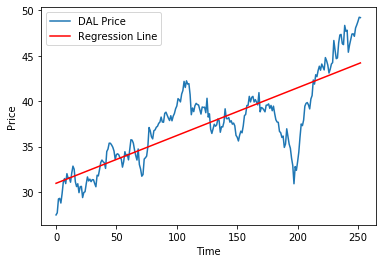

In [13]:
from pandas_datareader import data
# Load pricing data for an asset
start = '2014-01-01'
end = '2015-01-01'
y = data.get_data_yahoo('DAL', start, end)['Close']
x = np.arange(len(y))

# Regress pricing data against time
model = regression.linear_model.OLS(y, sm.add_constant(x)).fit()

# Construct the fit line
prediction = model.params[0] + model.params[1]*x

# Plot pricing data and regression line
plt.plot(x,y)
plt.plot(x, prediction, color='r')
plt.legend(['DAL Price', 'Regression Line'])
plt.xlabel('Time')
plt.ylabel('Price')

# Print summary of regression results
model.summary()

### 自相关检验

我们可以测试我们的价格和残差的自相关。我们将使用基于Ljun-Box测试的内置方法来完成此任务。该测试计算第n个滞后数据点预测当前的概率。如果没有给出最大滞后，那么该函数计算最大滞后并返回所有滞后到最大滞后的p值。我们可以在这里看到，对于最近的5个数据点，与当前存在显著的相关性。因此，我们认为这两个数据是自相关的。

我们也会为了好玩而测试是否正态。

In [16]:
_, prices_qstats, prices_qstat_pvalues = statsmodels.tsa.stattools.acf(y, qstat=True)
_, prices_qstats, prices_qstat_pvalues = statsmodels.tsa.stattools.acf(y-prediction, qstat=True)

print('Prices autocorrelation p-values', prices_qstat_pvalues) 
print('Residuals autocorrelation p-values', prices_qstat_pvalues) 

_, jb_pvalue, _, _ = statsmodels.stats.stattools.jarque_bera(y-prediction)

print('Jarque-Bera p-value that residuals are normally distributed', jb_pvalue) 

Prices autocorrelation p-values [5.95740213e-052 4.87274664e-096 1.02829781e-135 8.47084996e-172
 4.73269734e-204 3.41262637e-232 5.87198237e-257 7.25588001e-279
 2.79670200e-298 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
Residuals autocorrelation p-values [5.95740213e-052 4.87274664e-096 1.02829781e-135 8.47084996e-172
 4.73269734e-204 3.41262637e-232 5.87198237e-257 7.25588001e-279
 2.79670200e-298 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.000

## Newey-West

Newey-West法是一种计算自相关方差的方法。当存在自相关时，朴素方差计算实际上会产生不准确的标准误差。

我们可以尝试改变回归方程来消除序列相关。一个更简单的修复方法是使用适当的方法调整标准误差，并使用调整后的值来检查显著性。下面我们使用`statsmodels`中的newey-west方法来计算调整后的系数标准误差。他们比那些最初报告的回归，这是我们所期望的正相关误差。

In [9]:
from math import sqrt

# Find the covariance matrix of the coefficients
cov_mat = stats.sandwich_covariance.cov_hac(model)

# Print the standard errors of each coefficient from the original model and from the adjustment
print 'Old standard errors:', model.bse[0], model.bse[1]
print 'Adjusted standard errors:', sqrt(cov_mat[0,0]), sqrt(cov_mat[1,1])

Old standard errors: 0.343510916163 0.00236807424591
Adjusted standard errors: 0.507679344438 0.00511956168035


 # 多重共线性

当使用多个自变量时，检查多重共线性是很重要的;即各自变量之间近似的线性关系，如
$$ X_2 \approx 5 X_1 - X_3 + 4.5 $$

在多重共线性的情况下，我们很难确定每个变量的独立影响，因为我们可以根据线性关系改变周围的系数而不改变模型。对于真正不必要的变量，这通常不会影响模型的准确性，但会影响我们的分析。特别地，估计系数将有很大的标准误差。系数也不再代表每个变量的部分效应，因为在多重共线性中，我们不能在保持其他变量不变的情况下改变一个变量。

自变量之间的高相关性是多重共线性的表现。然而，这是不够的，因为我们想要检测其中一个变量与其他变量的线性组合之间的相关性。如果我们对系数有高的r方但是低的t统计量(拟合很好但是系数没有被精确估计)，我们可能会怀疑多重共线性。为了解决这个问题，我们可以去掉线性关系中涉及的一个自变量。

例如，用两个股票指数作为自变量可能会导致多重共线性。下面我们可以看到，删除其中一个可以在不损害R平方的情况下改进t统计。

这里要确定的另一件重要事情是哪个变量可能是偶然变量。如果我们假设市场同时影响MDY和HPQ，那么市场就是我们在预测模型中应该使用的变量。

R-squared: 0.8862548909952637
t-statistics of coefficients:
 const   -11.762777
x1       23.970378
x2       -5.741289
dtype: float64


Text(0, 0.5, 'Price')

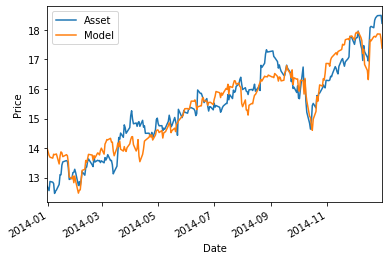

In [20]:
# Load pricing data for asset and two market indices
start = '2014-01-01'
end = '2015-01-01'
b1 = data.get_data_yahoo('SPY', start, end)['Close']
b2 = data.get_data_yahoo('MDY', start, end)['Close']
a = data.get_data_yahoo('HPQ', start, end)['Close']

# Run multiple linear regression
mlr = regression.linear_model.OLS(a, sm.add_constant(np.column_stack((b1,b2)))).fit()

# Construct fit curve using dependent variables and estimated coefficients
mlr_prediction = mlr.params[0] + mlr.params[1]*b1 + mlr.params[2]*b2

# Print regression statistics 
print( 'R-squared:', mlr.rsquared_adj)
print('t-statistics of coefficients:\n', mlr.tvalues) 

# Plot asset and model
a.plot()
mlr_prediction.plot()
plt.legend(['Asset', 'Model']);
plt.ylabel('Price')

R-squared: 0.8717705607265488
t-statistics of coefficients:
 const   -21.647815
Close    41.403229
dtype: float64


D:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


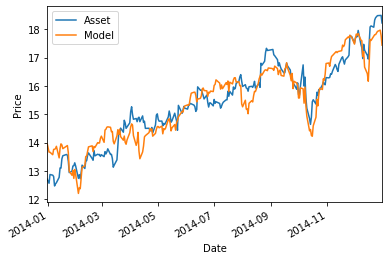

In [21]:
# Perform linear regression
slr = regression.linear_model.OLS(a, sm.add_constant(b1)).fit()
slr_prediction = slr.params[0] + slr.params[1]*b1

# Print fit statistics
print ('R-squared:', slr.rsquared_adj)
print ('t-statistics of coefficients:\n', slr.tvalues)

# Plot asset and model
a.plot()
slr_prediction.plot()
plt.ylabel('Price')
plt.legend(['Asset', 'Model']);

# 例如:安斯科姆的四重奏

Anscombe构建了4个数据集，这些数据集不仅在每个变量中具有相同的均值和方差，而且具有相同的相关系数、回归线和R平方回归值。下面，我们测试这个结果并绘制数据集。快速浏览一下图表就会发现，只有第一个数据集满足回归模型的假设。因此，其他三个的高r方值没有意义，这与我们的直觉一致，即其他三个没有被最佳拟合线很好地建模.

Cofficients: [3.00009091 0.50009091] [3.00090909 0.5       ] [3.00245455 0.49972727] [3.00172727 0.49990909]
Pearson r: 0.8164205163448399 0.8162365060002427 0.8162867394895982 0.8165214368885029
R-squared: 0.666542459508775 0.6662420337274844 0.6663240410665593 0.6667072568984653


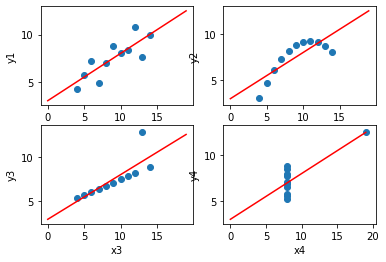

In [22]:
from scipy.stats import pearsonr

# Construct Anscombe's arrays
x1 = [10, 8, 13, 9, 11, 14, 6, 4, 12, 7, 5]
y1 = [8.04, 6.95, 7.58, 8.81, 8.33, 9.96, 7.24, 4.26, 10.84, 4.82, 5.68]
x2 = [10, 8, 13, 9, 11, 14, 6, 4, 12, 7, 5]
y2 = [9.14, 8.14, 8.74, 8.77, 9.26, 8.10, 6.13, 3.10, 9.13, 7.26, 4.74]
x3 = [10, 8, 13, 9, 11, 14, 6, 4, 12, 7, 5]
y3 = [7.46, 6.77, 12.74, 7.11, 7.81, 8.84, 6.08, 5.39, 8.15, 6.42, 5.73]
x4 = [8, 8, 8, 8, 8, 8, 8, 19, 8, 8, 8]
y4 = [6.58, 5.76, 7.71, 8.84, 8.47, 7.04, 5.25, 12.50, 5.56, 7.91, 6.89]

# Perform linear regressions on the datasets
slr1 = regression.linear_model.OLS(y1, sm.add_constant(x1)).fit()
slr2 = regression.linear_model.OLS(y2, sm.add_constant(x2)).fit()
slr3 = regression.linear_model.OLS(y3, sm.add_constant(x3)).fit()
slr4 = regression.linear_model.OLS(y4, sm.add_constant(x4)).fit()

# Print regression coefficients, Pearson r, and R-squared for the 4 datasets
print('Cofficients:', slr1.params, slr2.params, slr3.params, slr4.params) 
print('Pearson r:', pearsonr(x1, y1)[0], pearsonr(x2, y2)[0], pearsonr(x3, y3)[0], pearsonr(x4, y4)[0]) 
print('R-squared:', slr1.rsquared, slr2.rsquared, slr3.rsquared, slr4.rsquared) 

# Plot the 4 datasets with their regression lines
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
xs = np.arange(20)
ax1.plot(slr1.params[0] + slr1.params[1]*xs, 'r')
ax1.scatter(x1, y1)
ax1.set_xlabel('x1')
ax1.set_ylabel('y1')
ax2.plot(slr2.params[0] + slr2.params[1]*xs, 'r')
ax2.scatter(x2, y2)
ax2.set_xlabel('x2')
ax2.set_ylabel('y2')
ax3.plot(slr3.params[0] + slr3.params[1]*xs, 'r')
ax3.scatter(x3, y3)
ax3.set_xlabel('x3')
ax3.set_ylabel('y3')
ax4.plot(slr4.params[0] + slr4.params[1]*xs, 'r')
ax4.scatter(x4,y4)
ax4.set_xlabel('x4')
ax4.set_ylabel('y4');

## 参考
* "Quantitative Investment Analysis", by DeFusco, McLeavey, Pinto, and Runkle